In [1]:
import numpy as np
import qmt
import imt
import ring
from imt.utils.view import view
from imt.utils.view import VisOptions
import matplotlib.pyplot as plt
import tree
import pandas as pd

In [50]:
# LOAD DATA
file = "C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/Daten/IMU/Dict_Frames/S0133_dict_frame.npy"  # noqa: E501
#sensors = ["S0333", "S1094", "S0593", "S0994", "S0477"] # 5 Sensoren
sensors = ["S1094", "S0593", "S0994", "S0477"] # ohne Sternum, beide Knie
#sensors = ["S1094", "S0593"]   # 2 Sensoren, nur Knie rechts
data = np.load(file, allow_pickle=True).item()
Hz = 52
Hz_resample = 30 
Ts=0.01

In [ ]:
# CROP DATASET TO GET ONLY N Seconds
#n = 50   # Wie viele Sekunden des Datensatz betrachtet
#ts_crop = int(len(data[sensors[0]]["acc"]) - n/(1/Hz)) 
    
# PREPARE DATA
imu_data = {
    i: dict(acc=data[sensors[i]]["acc"], gyr=data[sensors[i]]["gyr_rad"])
    #i: dict(acc=data[sensors[i]]["acc"][:-ts_crop], gyr=data[sensors[i]]["gyr_rad"][:-ts_crop])
    for i in range(len(sensors))  
}
imu_data = imt.utils.resample(imt.utils.crop_tail(imu_data, Hz), Hz, 1/Ts)

"""imu_data[0] = dict(
    acc=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["acc"]),
    gyr=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["gyr"]),
)       # 5 Sensoren"""

`crop_tail`: Crop off at t=180.07692307692307s


'imu_data[0] = dict(\n    acc=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["acc"]),\n    gyr=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["gyr"]),\n)       # 5 Sensoren'

In [53]:
# ESTIMATE ORIENTATIONS
rel_method = imt.methods.RING(axes_directions=np.array([1.0, 0, 0]))
#graph = [-1, 0, 1, 0, 3]
graph = [-1, 0, -1, 2] # ohne Sternum, beide Knie
#graph = [-1, 0]    # nur Knie rechts
solver = imt.Solver(graph, [imt.methods.VQF(offline=True)] +
                    [imt.wrappers.JointTracker1D(rel_method)] +
                    [imt.methods.VQF(offline=True)] +
                    [imt.wrappers.JointTracker1D(rel_method)], 
                    Ts=Ts)
qhat, extras = solver.step(imu_data)

In [54]:
# Extract timesteps
T = qhat[0].shape[0]
ts = np.round(np.arange(T)*Ts, 2)
angle_kr = -np.rad2deg(extras[1]["joint_angle_rad"])
angle_kl = -np.rad2deg(extras[3]["joint_angle_rad"])

In [ ]:
factor = (1/Ts)/Hz_resample
indices = np.round(np.arange(0, len(ts), factor), 1)  # Select every nth index
ts_resample = np.interp(indices, np.arange(len(ts)), ts)
angle_kr_resample = np.interp(indices, np.arange(len(ts)), angle_kr)
angle_kl_resample = np.interp(indices, np.arange(len(ts)), angle_kl)

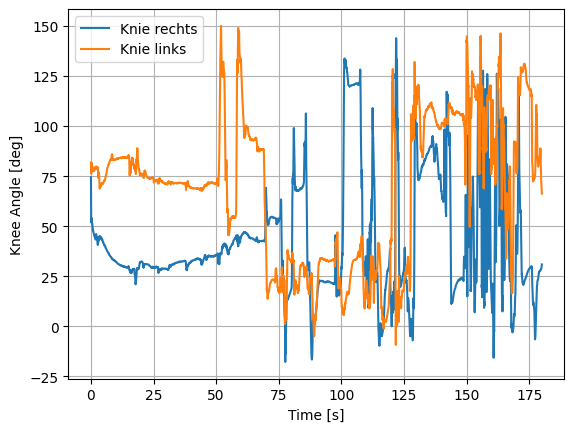

In [57]:
plt.plot(ts_resample, angle_kr_resample, label="Knie rechts")
plt.plot(ts_resample, angle_kl_resample, label="Knie links")
plt.grid()
plt.legend()
plt.ylabel("Knee Angle [deg]")
plt.xlabel("Time [s]")
plt.show()